### ***The Second Approach for ECG Signal Analysis and Classification :***

**Note that : To test the models with the test set you have ready in a file , just upload the file and change the name of the test file path in the final section of the other notebook 'Test_model_function_2nd_approach.ipynb' (the last cell) then run it to get the performance of the test**

## **Team members**
1-Djamila Amani Hamza

2-Rym Selmani

3-Oumaima Maatar

4-Hiba Ilmain

# 2nd Approach :


## Introduction
In our quest to classify ECG signals into normal and abnormal categories, this study adopts an approach that transforms ECG data into *image-like representations* for analysis by advanced neural network models. This method differs from traditional feature extraction techniques and aligns with our goal of leveraging the power of deep learning for better classification accuracy.

**First Approach Recap:**
Previously, we focused on extracting features directly from ECG signals and feeding these features into models for classification. This approach relied on standard signal processing and statistical methods to derive meaningful features from the raw ECG data.

**Second Approach Overview:**
In this second approach, we transform ECG signals into rich visual formats that neural networks can process more effectively. By converting the time-series data into images, we allow models to capture complex patterns and relationships in the data that might be missed with conventional feature extraction.

**Key components of this approach include:**

**Data Transformation Techniques:**

* **Piecewise Aggregate Approximation (PAA):** Simplifies the time-series by averaging sections of data, reducing dimensionality while preserving important trends.
* **Time-Frequency Transformations:**
* **Short-Time Fourier Transform (STFT)**: Converts signals into a time-frequency representation, providing insights into how signal properties change over time.
* **Continuous Wavelet Transform (CWT):** Decomposes signals into wavelets, allowing analysis at multiple scales and capturing both frequency and temporal information.
* **Image Representations for Neural Networks:**
* **Gramian Angular Difference Field (GADF):** Transforms the ECG data into polar coordinates to create images that highlight angular relationships within the signals.
* **Recurrence Plot (RP):** Visualizes the recurrence of states within the ECG signals, offering a dynamic way to represent the data as images.
  
**Neural Network Models:**
* Convolutional Neural Networks **(CNNs)**: Leverage their strength in image processing to classify ECG signals based on their visual transformations.
* Long Short-Term Memory Networks **(LSTMs)**: Capture temporal dependencies and long-term patterns, particularly useful for sequential ECG data.
  
    By integrating these transformation techniques and neural network models, we aim to uncover the most effective methods for classifying ECG signals. This approach allows us to exploit the strengths of CNNs and LSTMs in handling complex data, potentially leading to more accurate and reliable ECG signal classification. Through this study, we hope to advance the understanding and application of ECG signal processing in the medical field.

## 1.Data Loading and Visualization

We begin by loading the ECG dataset and visualizing the original signals. This helps us understand the nature of the data and the differences between classes.


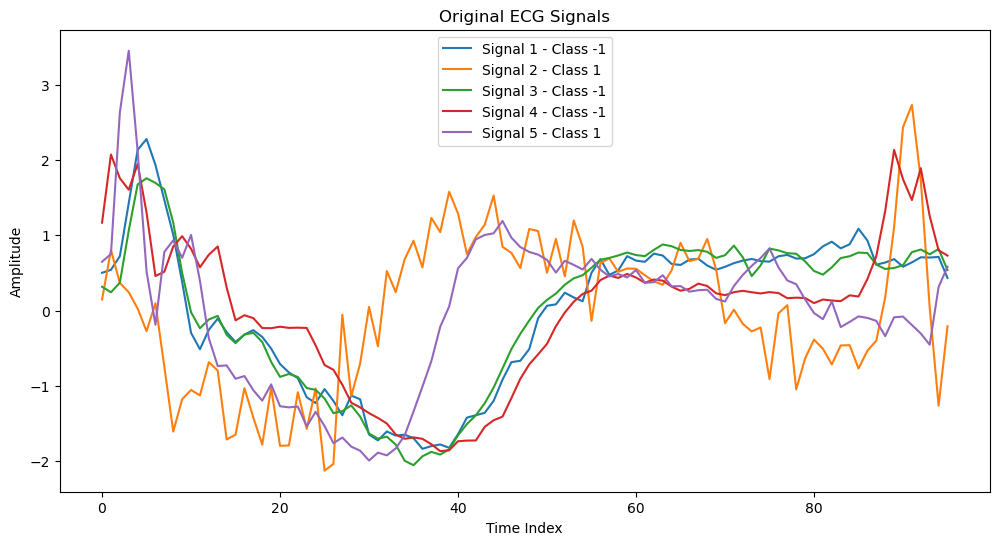

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'ECG200_TRAIN.txt'
data = np.loadtxt(file_path)

# Separate labels and features
labels = data[:, 0]
features = data[:, 1:]

# Visualize the first few signals
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(features[i, :], label=f'Signal {i+1} - Class {int(labels[i])}')
plt.title('Original ECG Signals')
plt.xlabel('Time Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


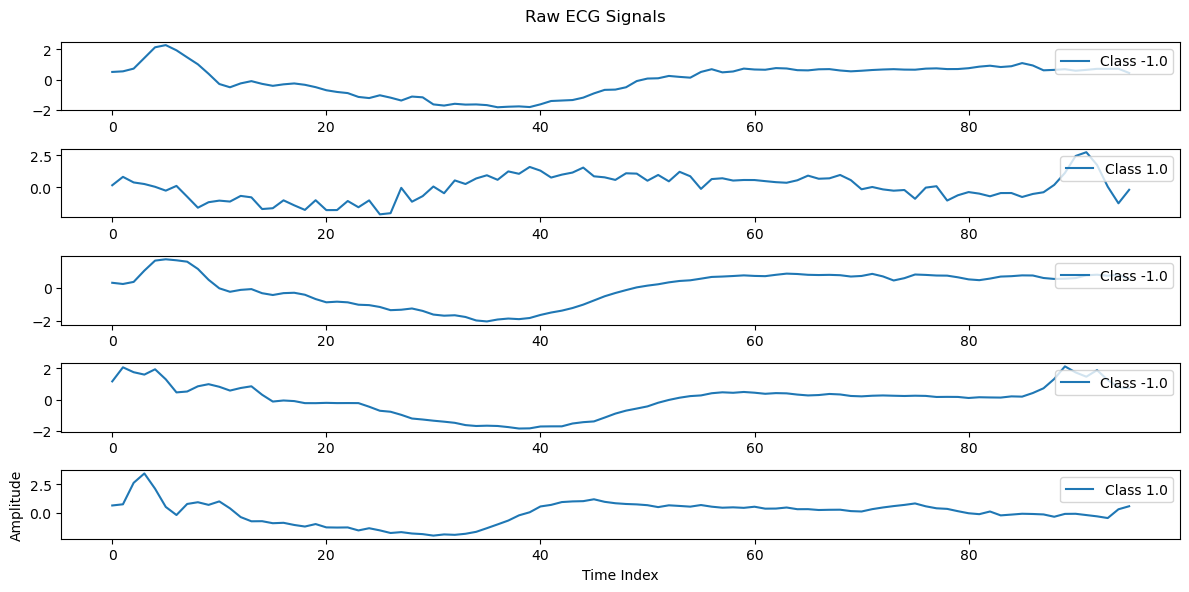

In [98]:
import matplotlib.pyplot as plt

# Plotting a few examples of the raw ECG signals
def plot_raw_ecg_signals(signals, labels, num_signals=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_signals):
        plt.subplot(num_signals, 1, i+1)
        plt.plot(signals[i], label=f'Class {labels[i]}')
        plt.legend(loc='upper right')
    plt.suptitle('Raw ECG Signals')
    plt.xlabel('Time Index')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Plot first few signals from each class
plot_raw_ecg_signals(features[:10], labels[:10], num_signals=5)


## 2.Transformation Methods

To capture the time-frequency characteristics of ECG signals, we apply Short-Time Fourier Transform (STFT) and Continuous Wavelet Transform (CWT). These methods help us analyze the frequency content of the signals over time.



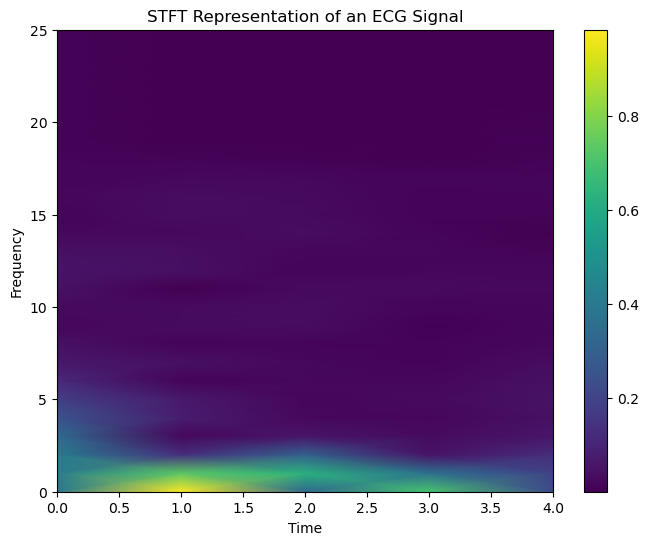

In [80]:
from scipy.signal import stft

# STFT transformation
def compute_stft(signals):
    stft_images = []
    for signal in signals:
        _, _, Zxx = stft(signal, fs=100, nperseg=50)
        stft_images.append(np.abs(Zxx))
    return np.array(stft_images)

train_stft = compute_stft(features)

# Reshape the data to fit into Conv2D (3D input: height, width, channels)
train_stft = train_stft[..., np.newaxis]

# Visualize an STFT image
plt.figure(figsize=(8, 6))
plt.pcolormesh(np.abs(train_stft[0, :, :, 0]), shading='gouraud')
plt.title('STFT Representation of an ECG Signal')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


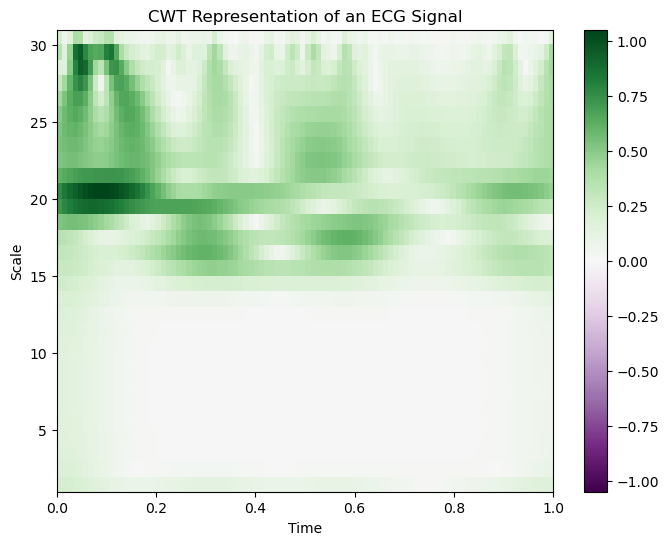

In [81]:
from scipy.signal import cwt, morlet

# CWT transformation
def compute_cwt(signals, widths=np.arange(1, 31)):
    cwt_images = []
    for signal in signals:
        cwt_matr = cwt(signal, morlet, widths)
        cwt_images.append(np.abs(cwt_matr))
    return np.array(cwt_images)

train_cwt = compute_cwt(features)

# Reshape the data to fit into Conv2D (3D input: height, width, channels)
train_cwt = train_cwt[..., np.newaxis]

# Visualize a CWT image
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(train_cwt[0, :, :, 0]), extent=[0, 1, 1, 31], cmap='PRGn', aspect='auto', vmax=abs(train_cwt[0]).max(), vmin=-abs(train_cwt[0]).max())
plt.title('CWT Representation of an ECG Signal')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.colorbar()
plt.show()


## 3.Model Training 

### **CNN with Short-Time Fourier Transform (STFT):**
Train a CNN on the spectrograms generated by STFT, capturing the frequency dynamics over time, which is essential for identifying abnormal rhythms in ECG data.

### **CNN with Continuous Wavelet Transform (CWT):**

* Apply CWT to the ECG signals to create time-frequency representations that capture variations at multiple scales.
* Transform the ECG signals into wavelet coefficient images. These images highlight both the frequency components and their temporal changes.
* Use these CWT-transformed images as inputs to train a CNN. The CNN will learn to identify features in the wavelet coefficients that differentiate between normal and abnormal signals.

### **LSTM:**
To capture Temporal Dependencies

### **ECG Signal Classification Using PAA, RP, and GADF Transformations**
we explore another approach to classify ECG signals by applying Piecewise Aggregate Approximation (PAA), Recurrence Plot (RP), and Gramian Angular Difference Field (GADF) transformations. These features are then used to train a Convolutional Neural Network (CNN) model.

In [82]:
# Convert labels from -1, 1 to 0, 1
labels = np.where(labels == -1, 0, labels)

# Ensure labels are properly adjusted
print(np.unique(labels))  # Output should be: [0 1]


[0. 1.]


### Short-Time Fourier Transform (STFT) AND  Continuous Wavelet Transform (CWT)

**Intuition**
* STFT provides a time-frequency representation of the signal, capturing both the frequency content and its evolution over time. This is particularly valuable for ECG data, where both the frequency characteristics and their changes over time can indicate different heart conditions.

**Steps**
* **Short-Time Fourier Transform (STFT):**
Apply STFT to convert the time series into a spectrogram. This provides a detailed view of how the signal’s frequency content varies over time.
* **CNN on Spectrograms:**
Use the spectrograms as input to a convolutional neural network (CNN) to classify the signals based on their time-frequency characteristics.


**Continuous Wavelet Transform (CWT):**
CWT is another time-frequency transformation technique that provides a more flexible analysis of signals at various scales and resolutions. Unlike STFT, which uses a fixed window size, CWT uses wavelets of varying widths, offering better localization in both time and frequency domains. This is crucial for detecting transient features and changes in ECG signals that may indicate abnormalities.

Shape of STFT transformed data: (100, 25, 5, 1)
Applying upsampling to STFT data...
Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/up_sampling2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5297 - loss: 0.6741 - val_accuracy: 0.5500 - val_loss: 0.6790
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7391 - loss: 0.5881 - val_accuracy: 0.5500 - val_loss: 0.7499
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7408 - loss: 0.5805 - val_accuracy: 0.5500 - val_loss: 0.7522
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7408 - loss: 0.5420 - val_accuracy: 0.5500 - val_loss: 0.7130
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6870 - loss: 0.6175 - val_accuracy: 0.5500 - val_loss: 0.6735
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7365 - loss: 0.5291 - val_accuracy: 0.5500 - val_loss: 0.6779
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7469 - loss: 0.5211 - val_accuracy: 0.5500 - val_loss: 0.7025
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7512 - loss: 0.5062 - val_accuracy: 0.5500 - val_loss: 0.6616
Epoch 9/20
5/5 ━━━

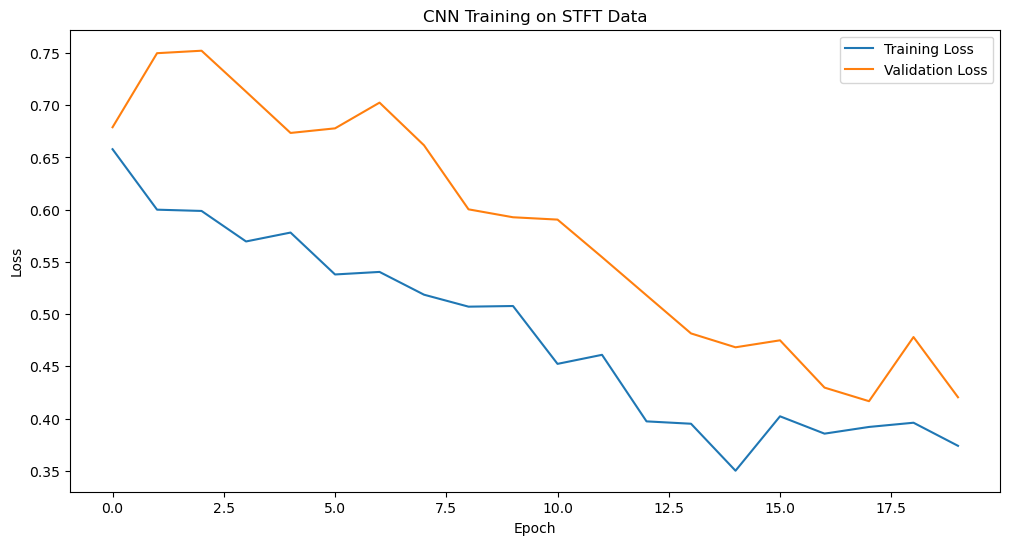

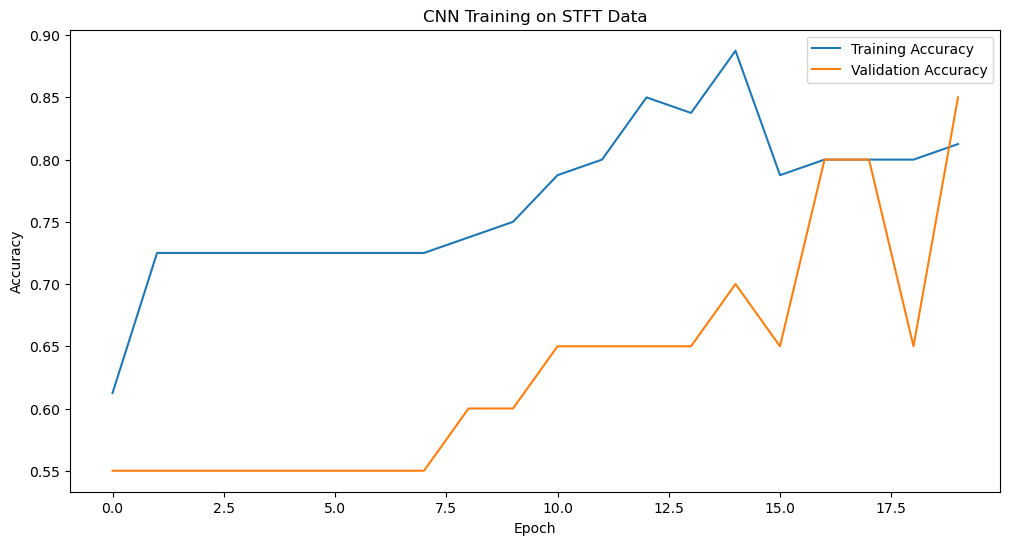

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report for STFT Model:
              precision    recall  f1-score   support

         0.0       0.88      0.71      0.79        31
         1.0       0.88      0.96      0.92        69

    accuracy                           0.88       100
   macro avg       0.88      0.83      0.85       100
weighted avg       0.88      0.88      0.88       100



In [83]:
from scipy.signal import stft
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Adjusted STFT function with new parameters
def compute_stft(signals, fs=100, nperseg=48, noverlap=24):
    stft_images = []
    for signal in signals:
        _, _, Zxx = stft(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
        stft_images.append(np.abs(Zxx))
    return np.array(stft_images)

# Apply STFT with updated parameters
train_stft = compute_stft(features)

# Reshape the STFT data to fit into Conv2D (3D input: height, width, channels)
train_stft = train_stft[..., np.newaxis]

# Check the shape of the transformed data
print(f"Shape of STFT transformed data: {train_stft.shape}")

# Apply upsampling if dimensions are too small
if train_stft.shape[1] < 10 or train_stft.shape[2] < 10:
    print("Applying upsampling to STFT data...")
    upsample_factor = 2
    model_stft = Sequential([
        UpSampling2D(size=(upsample_factor, upsample_factor), input_shape=train_stft.shape[1:]),
        Conv2D(16, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
else:
    # Build the CNN model
    model_stft = Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=train_stft.shape[1:]),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

# Compile the CNN model
model_stft.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
history_stft = model_stft.fit(train_stft, labels, epochs=20, batch_size=16, validation_split=0.2)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_stft.history['loss'], label='Training Loss')
plt.plot(history_stft.history['val_loss'], label='Validation Loss')
plt.title('CNN Training on STFT Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_stft.history['accuracy'], label='Training Accuracy')
plt.plot(history_stft.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training on STFT Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate classification report
y_pred_stft = np.argmax(model_stft.predict(train_stft), axis=1)
print("Classification Report for STFT Model:")
print(classification_report(labels, y_pred_stft))


In [108]:
# Assuming you have already trained the STFT model and it is stored in 'model_stft'
model_stft.save('cnn_stft_model.h5')
print("CNN model trained on STFT data has been saved as 'cnn_stft_model.h5'.")


CNN model trained on STFT data has been saved as 'cnn_stft_model.h5'.


Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7389 - loss: 0.8928 - val_accuracy: 0.6000 - val_loss: 0.6421
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6911 - loss: 0.5507 - val_accuracy: 0.6000 - val_loss: 0.9496
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7740 - loss: 0.7557 - val_accuracy: 0.7000 - val_loss: 0.6573
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8863 - loss: 0.3537 - val_accuracy: 0.7500 - val_loss: 0.5727
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8198 - loss: 0.4151 - val_accuracy: 0.7500 - val_loss: 0.5739
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8708 - loss: 0.3546 - val_accuracy: 0.7500 - val_loss: 0.5942
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8580 - loss: 0.2894 - val_accuracy: 0.8000 - val_loss: 0.5124
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9035 - loss: 0.2369 - val_accuracy: 0.8000 - val_loss: 0.4561
Epoch 9/20


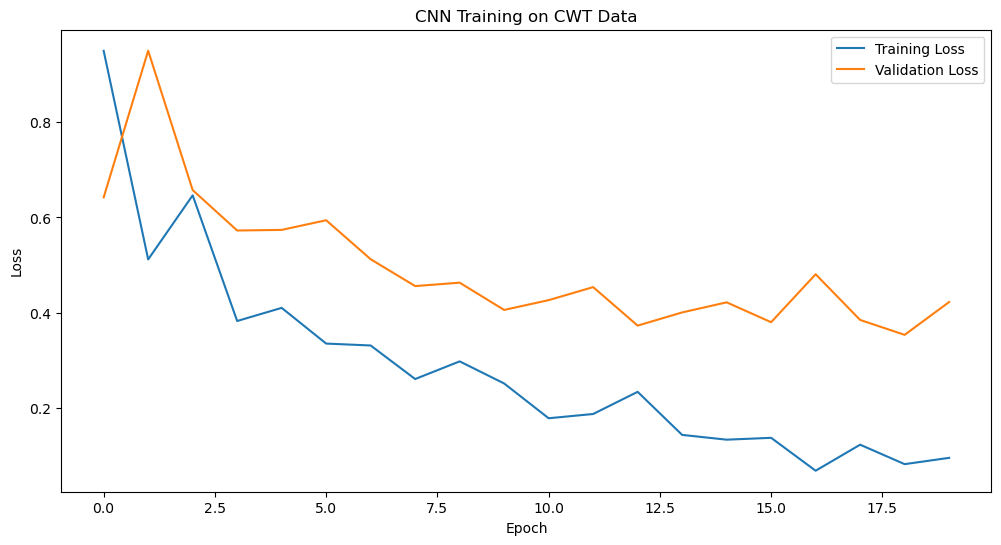

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Classification Report for CWT Model:
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92        31
         1.0       0.96      0.97      0.96        69

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.95      0.95       100



In [84]:
# Build and compile CNN model for CWT data
model_cwt = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_cwt.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_cwt.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
history_cwt = model_cwt.fit(train_cwt, labels, epochs=20, batch_size=16, validation_split=0.2)

# Plot training history for CWT
plt.figure(figsize=(12, 6))
plt.plot(history_cwt.history['loss'], label='Training Loss')
plt.plot(history_cwt.history['val_loss'], label='Validation Loss')
plt.title('CNN Training on CWT Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate classification report
y_pred_cwt = np.argmax(model_cwt.predict(train_cwt), axis=1)
print("Classification Report for CWT Model:")
print(classification_report(labels, y_pred_cwt))


In [109]:
# Assuming you have already trained the CWT model and it is stored in 'model_cwt'
model_cwt.save('cnn_cwt_model.h5')
print("CNN model trained on CWT data has been saved as 'cnn_cwt_model.h5'.")


CNN model trained on CWT data has been saved as 'cnn_cwt_model.h5'.


### **LSTM:**

**Why LSTM?**
**Capturing Temporal Dependencies:**

ECG signals contain critical information distributed over time, such as the QRS complex, P wave, and T wave, which are essential for accurate classification.
LSTMs can remember important events and their order, making them highly effective for capturing these time-dependent patterns.
Handling Variable Length Sequences:

Unlike traditional neural networks, LSTMs are adept at processing sequences of varying lengths. This flexibility is beneficial for ECG data, where the length of signals can vary between patients or recording sessions.

**Approach:**
* **Data Reshaping:**
The ECG signals are reshaped to fit the LSTM input requirements. LSTMs expect input data in the form of a three-dimensional array: samples, time steps, and features.
Each ECG signal is reshaped to (samples, time steps, features), where each sample represents one ECG signal, time steps represent the sequence of data points in the signal, and features represent the single feature dimension (amplitude of the signal).

* **Label Encoding:**
If the labels are provided as -1 and 1, they are converted to 0 and 1 to match the required format for classification in most neural network libraries.

* **Model Definition:**
The LSTM model is defined with a layer of 128 LSTM units, which allows the model to learn from the temporal dependencies in the ECG data.
A dropout layer is added to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
Finally, a dense layer with a softmax activation function is used to produce the output probabilities for the two classes.

* **Model Training:**
The model is trained using the Adam optimizer and sparse categorical cross-entropy loss, which is appropriate for multi-class classification problems with integer labels.
The model's performance is evaluated on a validation split of the training data to monitor for overfitting.

Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5807 - loss: 0.6901 - val_accuracy: 0.5500 - val_loss: 0.6738
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8517 - loss: 0.6353 - val_accuracy: 0.7000 - val_loss: 0.6551
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8182 - loss: 0.6049 - val_accuracy: 0.7000 - val_loss: 0.6371
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7040 - loss: 0.5412 - val_accuracy: 0.5500 - val_loss: 0.9581
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7623 - loss: 0.5310 - val_accuracy: 0.6000 - val_loss: 0.7002
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7545 - loss: 0.4847 - val_accuracy: 0.7000 - val_loss: 0.5849
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7842 - loss: 0.4111 - val_accuracy: 0.7000 - val_loss: 0.5887
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7679 - loss: 0.4364 - val_accuracy: 0.6000 - val_loss: 0.6672
Epoch 9/20


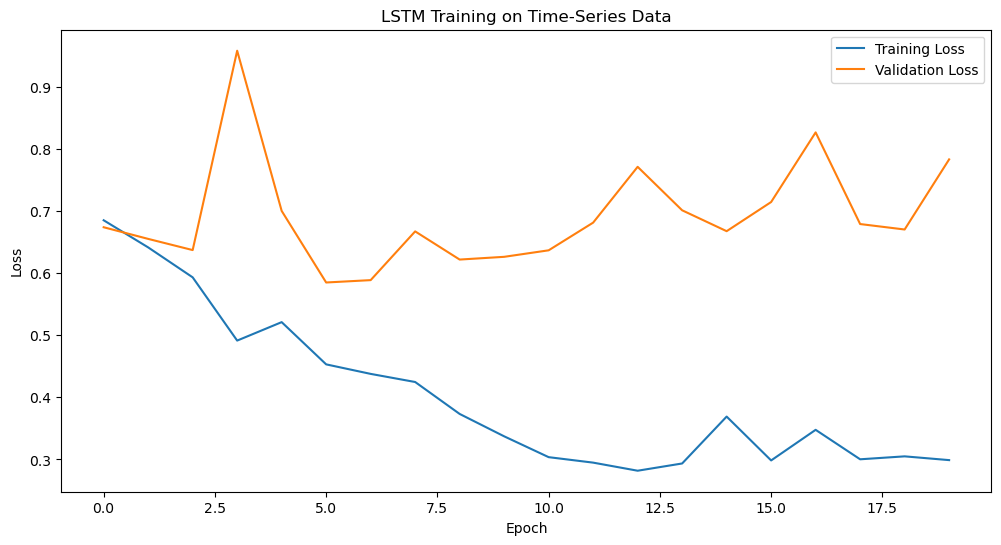

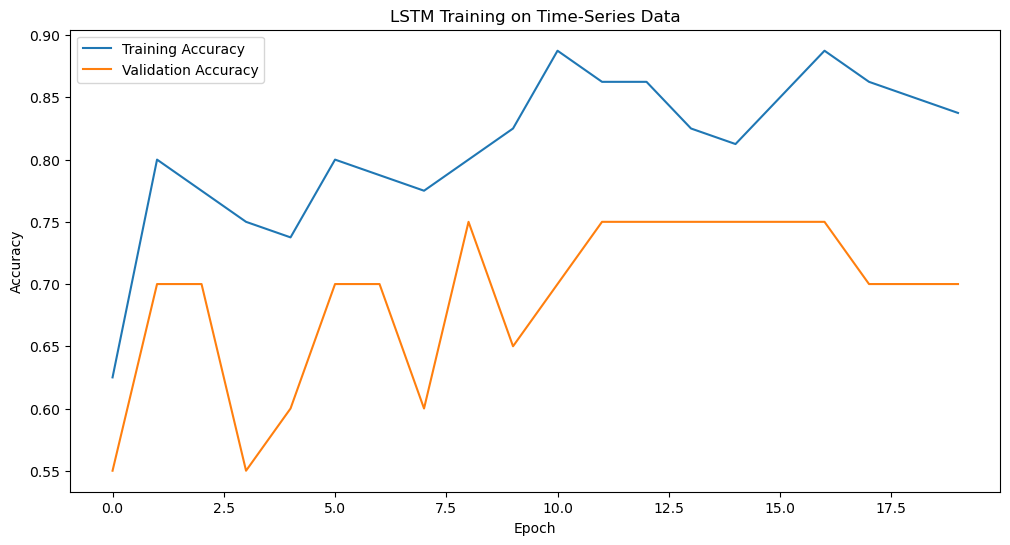

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Classification Report for LSTM Model:
              precision    recall  f1-score   support

         0.0       0.79      0.74      0.77        31
         1.0       0.89      0.91      0.90        69

    accuracy                           0.86       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.86      0.86      0.86       100



In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report

# Reshape the features to fit LSTM input requirements
# The shape should be (samples, time steps, features)
features_reshaped = features.reshape((features.shape[0], features.shape[1], 1))

# Convert labels to 0 and 1 if they are -1 and 1 respectively
labels = np.where(labels == -1, 0, labels)

# Define the LSTM model
model_lstm = Sequential([
    LSTM(128, input_shape=(features.shape[1], 1)),  # 128 units in LSTM layer
    Dropout(0.5),                                  # 50% dropout for regularization
    Dense(2, activation='softmax')                 # Output layer with 2 classes (0 and 1)
])

# Compile the LSTM model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history_lstm = model_lstm.fit(features_reshaped, labels, epochs=20, batch_size=16, validation_split=0.2)

# Plot training history for LSTM
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training on Time-Series Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy history for LSTM
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training on Time-Series Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate classification report
y_pred_lstm = np.argmax(model_lstm.predict(features_reshaped), axis=1)
print("Classification Report for LSTM Model:")
print(classification_report(labels, y_pred_lstm))


**Performance:**

Accuracy: The LSTM model achieves a training accuracy of approximately 85% and a validation accuracy around 70%, indicating that while the model learns from the training data, its generalization to new data is less stable compared to the other models.
Precision and Recall: The precision and recall are lower than those observed for the CNN-based models, with notable variability between the classes. Class 1 (positive) is better predicted than class 0 (negative).
Graph Analysis:

**Training vs. Validation:** The training accuracy steadily improves and remains high, while the validation accuracy shows significant fluctuations. This pattern suggests that while the LSTM is learning the training data well, it is struggling with consistent generalization to validation data.

###  Piecewise Aggregate Approximation (PAA) and Recurrence Plot (RP) Transformations

**Intuition**
* The goal of using PAA and RP is to simplify the ECG signals while retaining their essential characteristics. PAA reduces the data dimensionality by averaging adjacent segments, making the data more manageable. Recurrence Plot (RP) captures the recurrence of similar states in a system, providing a visual representation of the dynamic patterns in the ECG signals.

**Steps**  
* **Piecewise Aggregate Approximation (PAA):**
Down-sample the ECG signals by averaging segments of the data. This helps in reducing noise and dimensionality while preserving overall trends.

* **Recurrence Plot (RP):**
Generate recurrence plots for each down-sampled signal to visualize repeating patterns.


In [87]:
#piecewise aggregate approximation
def paa(data,ds_factor=2):
    #input datatype data : ndarray, dxn, d-number of series, n-number of samples in each series
    #input datatype ds_factor : int, downsampling factor, default is 2
    #output datatype ds_series : ndarray, downsampled time series
    
    d,ds_b = data.shape
    ds_length = int(ds_b/ds_factor)
    ds_series = np.empty(shape = (d,ds_length))
    for i in range (ds_length):
        ds_series[:,i] = np.mean(data[:,i*ds_factor:(i+1)*ds_factor],axis=1)
    return ds_series

#imaging time series as unthresholded recurrence plot
def r_plot(data,delay=0):
    #input datatype data : ndarray, 1xn, n-number of samples in each series
    #input datatype delay : int, delay embedding for RP formation, default value is 1
    #output datatype rp : ndarray, nxn, unthresholded recurrence plot for series
    
    transformed = np.zeros([2,len(data)-delay])
    transformed[0,:] = data[0:len(data)-delay]
    transformed[1,:] = data[delay:len(data)]
    rp = np.zeros([len(data)-delay,len(data)-delay])
    for i in range(len(rp)):
        temp = np.tile(transformed[:,i],(len(rp),1)).T-transformed
        temp2 = np.square(temp)
        rp[i,:] = np.sum(temp2,axis=0)
    return np.array(rp)

#rescaling series into range [0,1]
def rescale(data):
    #input datatype data: ndarray , dxn, d-number of series, n-number of samples in each series
    #output datatype rescaled: ndarray, dxn
    
    num=data-np.tile(np.mat(data.min(axis=1)).T,(1,np.shape(data)[1]))
    denom=np.tile(np.mat(data.max(axis=1)).T,(1,np.shape(data)[1]))-np.tile(np.mat(data.min(axis=1)).T,(1,np.shape(data)[1]))
    rescaled=np.multiply(num,1/denom)
    return rescaled

#imaging time series as Gramian Angular Difference Field (GADF)
def polar_rep (data):
    #input datatype data : ndarray, 1xn, n-number of samples in each series
    #output datatype phi : ndarray, 1xn 
    #output datatype r : ndarray, 1xn
    
    phi=np.arccos(data)
    r=(np.arange(0,np.shape(data)[1])/np.shape(data)[1])+0.1
    return phi,r
    
def GADF(data):
    #input datatype data : ndarray, 1xn, n-number of samples in each series
    #output datatype gadf : ndarray, nxn, GADF for series
    
    datacos = np.array(data)
    datasin = np.sqrt(1-datacos**2)
    gadf = datasin.T*datacos-datacos.T*datasin
    return gadf    

In [88]:
#loading dataset
# Load the dataset
train_path = 'ECG200_TRAIN.txt'

train_np = np.loadtxt(train_path)

# Extract signals and labels
train_labels = train_data[:, 0]
train_signals = train_data[:, 1:]



**Rescaling the Downsampled Signals**
**Objective:**
To normalize the downsampled ECG signals to a standard range, typically [0, 1]. Rescaling ensures all data points are on a comparable scale, which is essential for many machine learning algorithms to perform effectively.

**Why It Matters:**
Rescaling:
Prevents any single feature from dominating the learning process due to its scale.
Improves the stability and convergence speed of algorithms, particularly neural networks.
Facilitates a more balanced and fair analysis by bringing all data points to a common scale.

Text(0.5, 1.0, 'Rescaled Time Series')

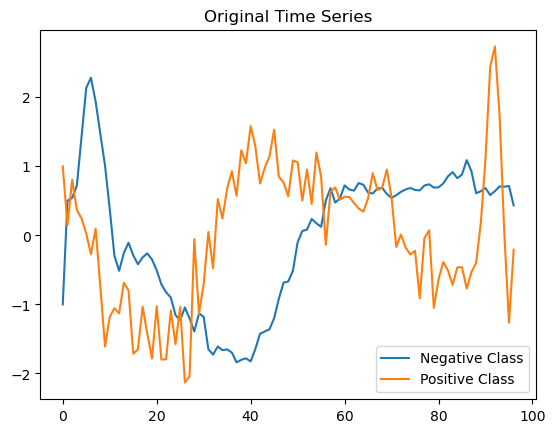

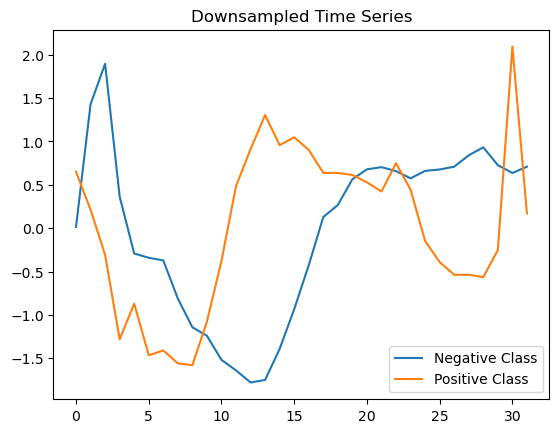

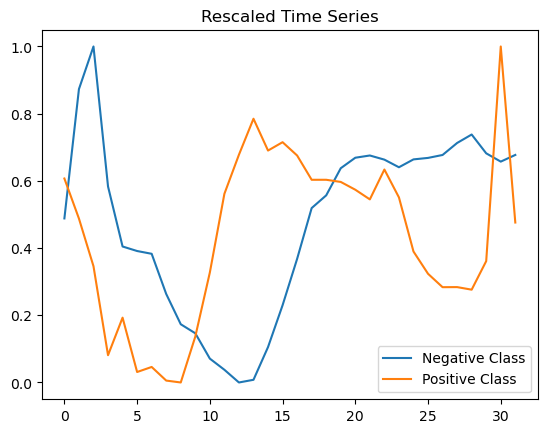

In [105]:
import matplotlib.pyplot as plt

toy_data=train_np[[0,1],:]
plt.plot(toy_data[0])
plt.plot(toy_data[1])
plt.legend(['Negative Class','Positive Class'])
plt.title('Original Time Series')

#downsampling
ds_data=paa(toy_data,3)
plt.figure()
plt.plot(ds_data[0])
plt.plot(ds_data[1])
plt.legend(['Negative Class','Positive Class'])
plt.title('Downsampled Time Series')

#rescaling
rescaled=rescale(ds_data)
plt.figure()
plt.plot(rescaled[0].T)
plt.plot(rescaled[1].T)
plt.legend(['Negative Class','Positive Class'])
plt.title('Rescaled Time Series')

**Visualizing Original ECG Signals**
The goal here is to visualize the raw ECG signals for both classes (1 and -1) without any preprocessing. This step allows us to see the inherent patterns and noise within the data, providing a baseline understanding before any transformations are applied.

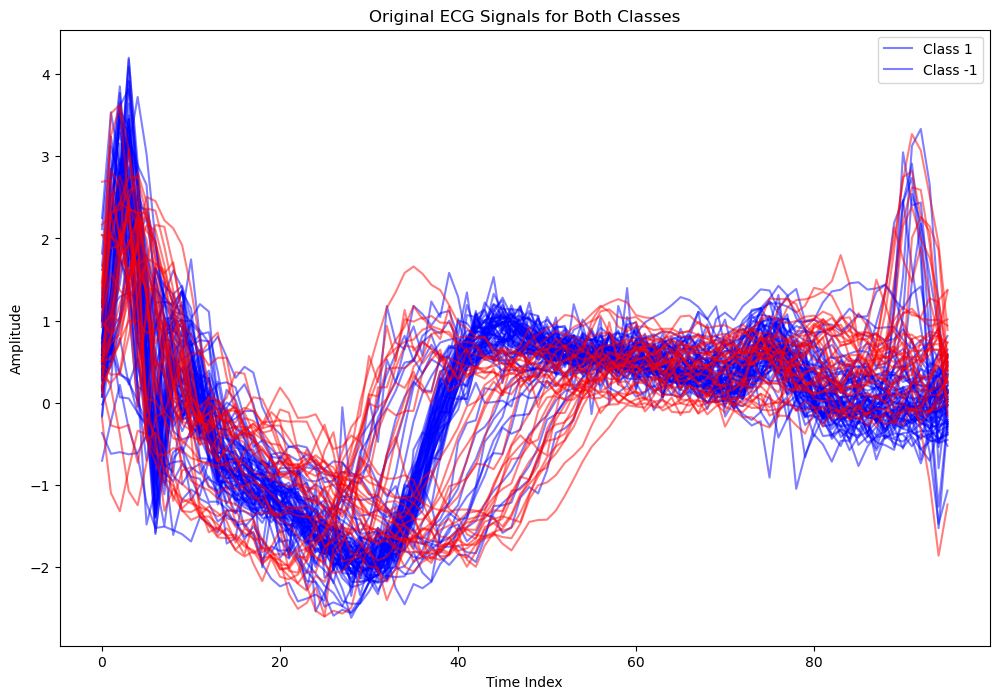

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Separate the labels and the features
labels = data[:, 0]  # First column as labels
features = data[:, 1:]  # Rest as features

# Separate data into two classes
class_1 = features[labels == 1]
class_minus_1 = features[labels == -1]

# Plotting
plt.figure(figsize=(12, 8))

# Plotting Class 1
for i in range(class_1.shape[0]):
    plt.plot(class_1[i, :], color='blue', alpha=0.5)  # Blue for class 1

# Plotting Class -1
for i in range(class_minus_1.shape[0]):
    plt.plot(class_minus_1[i, :], color='red', alpha=0.5)  # Red for class -1

# Adding titles and labels
plt.title('Original ECG Signals for Both Classes')
plt.xlabel('Time Index')
plt.ylabel('Amplitude')
plt.legend(['Class 1', 'Class -1'], loc='upper right')

# Show the plot
plt.show()


**Downsampling the ECG Signals**
To simplify the ECG signals using Piecewise Aggregate Approximation (PAA). Downsampling reduces the data's dimensionality, making it easier to handle and analyze while retaining the essential shape and patterns of the signals.

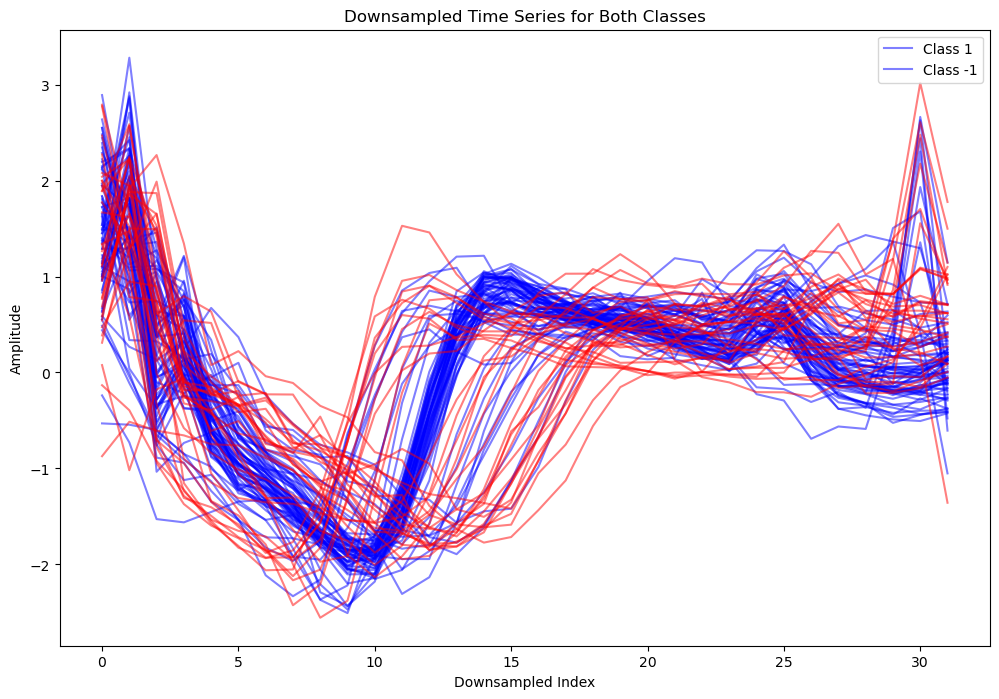

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Sample function for Piecewise Aggregate Approximation (PAA)
def paa(data, ds_factor=2):
    d, ds_b = data.shape
    ds_length = int(ds_b / ds_factor)
    ds_series = np.empty((d, ds_length))
    for i in range(ds_length):
        ds_series[:, i] = np.mean(data[:, i*ds_factor:(i+1)*ds_factor], axis=1)
    return ds_series


# Separate the labels and the features
labels = data[:, 0]  # First column as labels
features = data[:, 1:]  # Rest as features

# Downsample the data
ds_data = paa(features, 3)

# Separate data into two classes
class_1 = ds_data[labels == 1]
class_minus_1 = ds_data[labels == -1]

# Plotting
plt.figure(figsize=(12, 8))

# Plotting Class 1
for i in range(class_1.shape[0]):
    plt.plot(class_1[i, :], color='blue', alpha=0.5)  # Blue for class 1

# Plotting Class -1
for i in range(class_minus_1.shape[0]):
    plt.plot(class_minus_1[i, :], color='red', alpha=0.5)  # Red for class -1

# Adding titles and labels
plt.title('Downsampled Time Series for Both Classes')
plt.xlabel('Downsampled Index')
plt.ylabel('Amplitude')
plt.legend(['Class 1', 'Class -1'], loc='upper right')

# Show the plot
plt.show()


**Recurrence Plots (RP)**
**Objective:**
To transform the time series data into recurrence plots. These plots help visualize the recurrence of states within the ECG signals, providing a graphical representation of how often certain patterns reappear over time.

**Why It Matters:**
**Recurrence plots:**
Highlight the internal structure and dynamics of the ECG signals.
Make it easier to detect periodicities, trends, and anomalies in the data.
Provide a different perspective on the data that can be particularly useful for classification tasks, revealing patterns that might not be obvious in the raw time series.

Text(0.5, 1.0, 'RP-positive class')

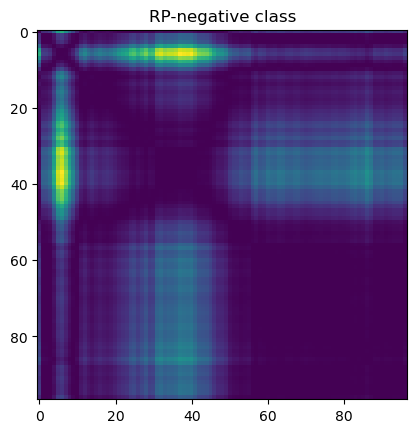

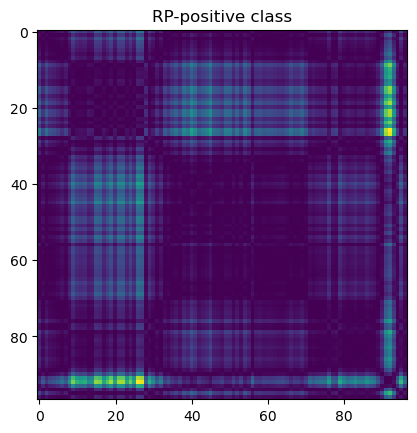

In [91]:
#RP embedding
RP=[]
for i in range(2):
    RP.append(r_plot(toy_data[i]))
    
plt.figure()
plt.imshow(RP[0])
plt.title('RP-negative class')
plt.figure()
plt.imshow(RP[1])
plt.title('RP-positive class')

### Gramian Angular Difference Field (GADF) Transformation

**Intuition**
* GADF transforms time series data into a two-dimensional image by capturing angular relationships over time. This method encodes the angular difference between time points into a matrix format, converting temporal data into a spatial representation. This is useful for feeding into convolutional neural networks (CNNs), enabling the network to learn spatial features from the ECG data.

**Steps**
* **Angular Representation:**
Convert each signal into its angular representation using trigonometric transformations.
* **GADF:**
Compute the GADF for each signal to create an image-like representation. This transformation leverages phase information of the signal, crucial for identifying complex patterns in ECG data.

Text(0.5, 1.0, 'GADF-positive class')

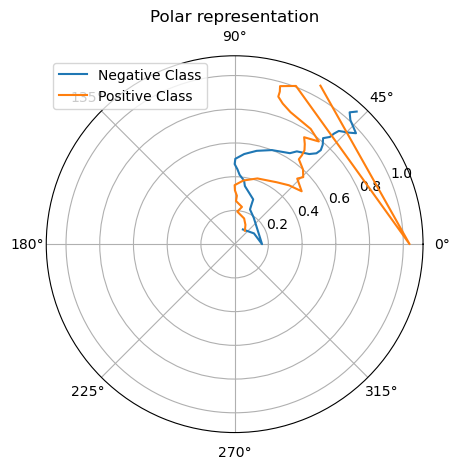

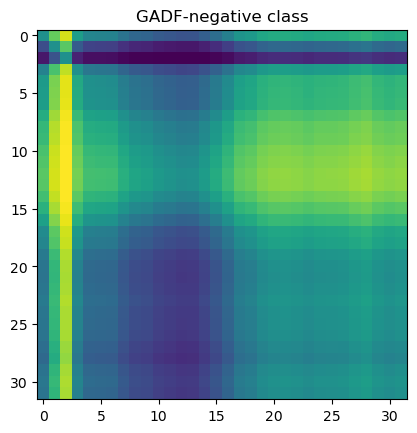

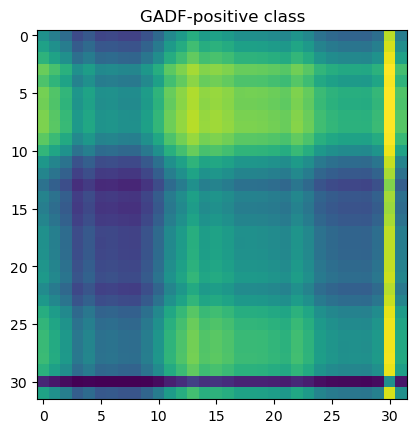

In [92]:
#polar embedding
phi_neg,r_neg=polar_rep(rescaled[0])
phi_pos,r_pos=polar_rep(rescaled[1])
plt.figure()
plt.polar(np.ravel(phi_neg),r_neg)
plt.polar(np.ravel(phi_pos),r_pos)
plt.legend(['Negative Class','Positive Class'])
plt.title('Polar representation')
plt.tight_layout()

#GADF embedding
GADF_i=[]
for i in range(2):
    GADF_i.append(GADF(rescaled[i]))
    
plt.figure()
plt.imshow(GADF_i[0])
plt.title('GADF-negative class')
plt.figure()
plt.imshow(GADF_i[1])
plt.title('GADF-positive class')

In [93]:
train_ds=paa(train_np,3)
train_img_rp=np.empty(shape=(len(train_ds),32,32))
for i in range(len(train_ds)):
    train_img_rp[i,:,:]=r_plot(train_ds[i,:])
print("generated rp images")

generated rp images


In [94]:
train_rs=rescale(train_ds)
train_img_gadf=np.empty(shape=(len(train_rs),32,32))
for i in range(len(train_rs)):
    train_img_gadf[i,:,:]=GADF(train_rs[i])
print("generated GADF images")

generated GADF images


### CNN with Recurrence Plot (RP):

Train a CNN using the recurrence plot images to classify the ECG signals. This approach captures temporal recurrence patterns in the data.


Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6609 - loss: 1.8286 - val_accuracy: 0.6500 - val_loss: 0.6838
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6304 - loss: 0.9277 - val_accuracy: 0.6000 - val_loss: 0.5957
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7951 - loss: 0.7055 - val_accuracy: 0.6500 - val_loss: 0.5730
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8295 - loss: 0.3890 - val_accuracy: 0.7000 - val_loss: 0.5281
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8149 - loss: 0.3809 - val_accuracy: 0.7000 - val_loss: 0.5171
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7604 - loss: 0.5033 - val_accuracy: 0.7000 - val_loss: 0.5036
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8290 - loss: 0.4033 - val_accuracy: 0.7000 - val_loss: 0.4990
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8875 - loss: 0.2733 - val_accuracy: 0.7000 - val_loss: 0.5072
Epoch 9/50
5/5 ━━━

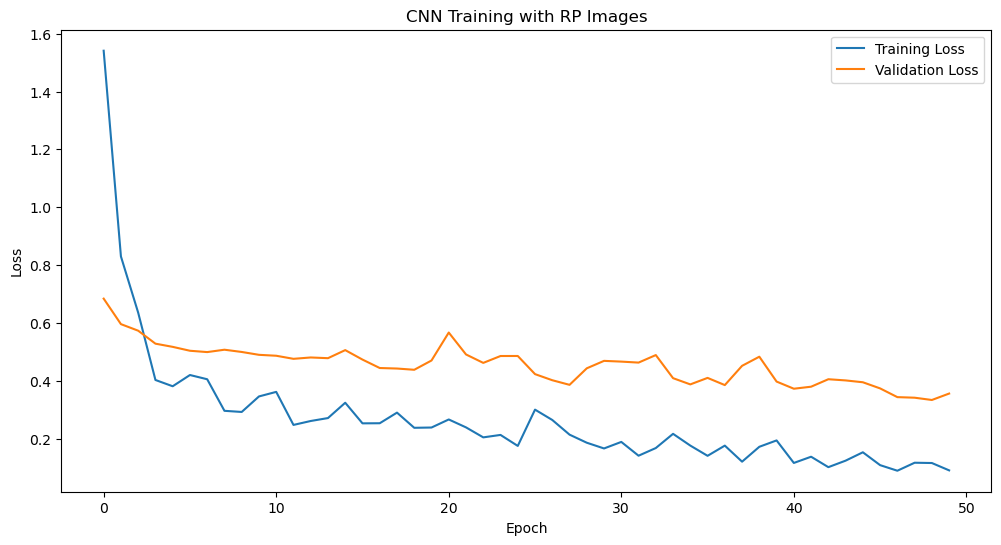

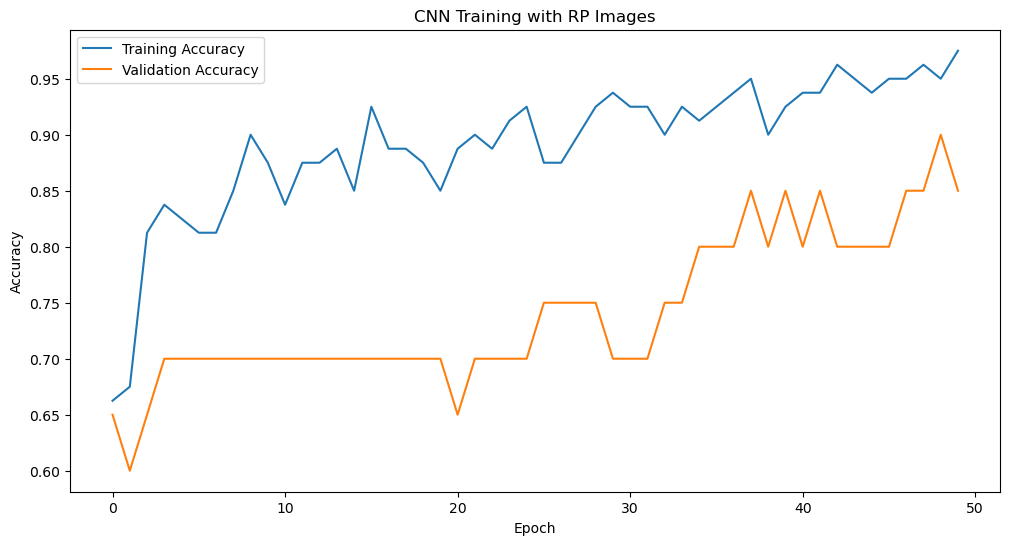

In [95]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# One-hot encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=2)

# Reshape RP images for CNN
train_img_rp = np.array(train_rp_images)
train_img_rp = train_img_rp[..., np.newaxis]

# Define and compile CNN model
model_rp = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(train_img_rp.shape[1], train_img_rp.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_rp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_rp = model_rp.fit(train_img_rp, train_labels_one_hot, epochs=50, batch_size=16, validation_split=0.2)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_rp.history['loss'], label='Training Loss')
plt.plot(history_rp.history['val_loss'], label='Validation Loss')
plt.title('CNN Training with RP Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_rp.history['accuracy'], label='Training Accuracy')
plt.plot(history_rp.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training with RP Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [106]:

model_rp.save('cnn_rp_model.h5')
print("CNN model trained on RP images has been saved as 'cnn_rp_model.h5'.")


CNN model trained on RP images has been saved as 'cnn_rp_model.h5'.


### CNN with Gramian Angular Difference Field (GADF):

Use the GADF images to train a CNN, allowing the network to learn from angular relationships in the ECG signals.

Shape of GADF transformed data: (100, 96, 96, 1)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


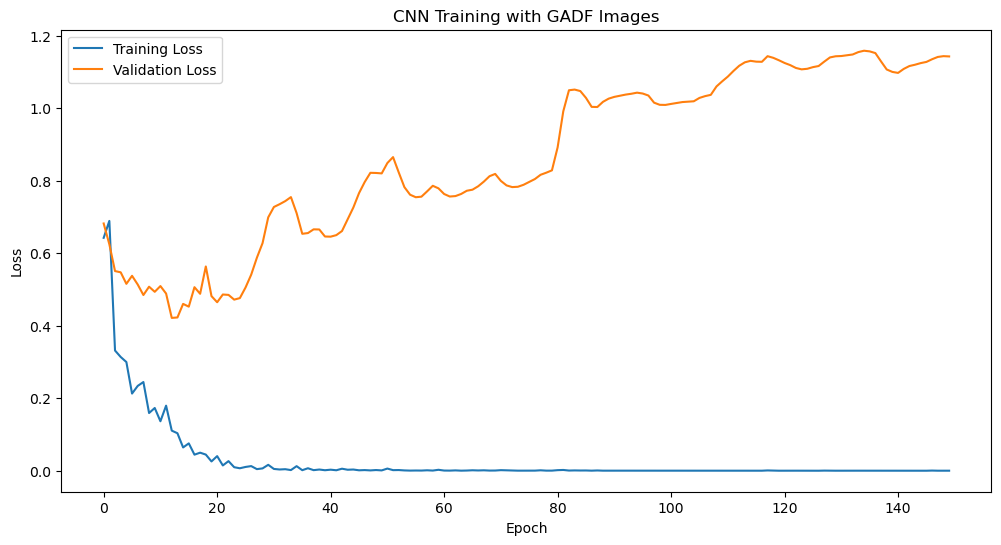

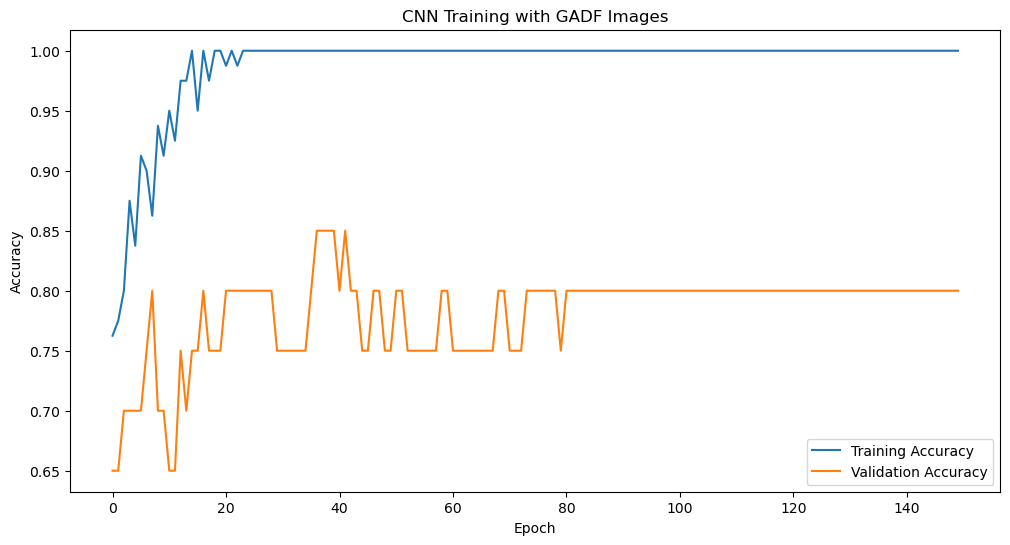

In [96]:
from __future__ import print_function
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Gramian Angular Difference Field (GADF) Transformation Function
def GADF(data):
    datacos = np.array(data)
    # Ensure the values are within the range [-1, 1] for valid arccos
    datacos = np.clip(datacos, -1, 1)
    datasin = np.sqrt(1 - datacos**2)
    gadf = np.outer(datasin, datacos) - np.outer(datacos, datasin)
    return gadf

# Load the dataset
train_path = 'ECG200_TRAIN.txt'  # Path to the training data
train_data = np.loadtxt(train_path)

# Extract signals and labels
train_labels = train_data[:, 0]  # First column as labels
train_signals = train_data[:, 1:]  # Remaining columns as features

# Apply GADF transformation
train_gadf_images = np.array([GADF(signal) for signal in train_signals])

# Handle NaNs resulting from invalid sqrt operations
train_gadf_images = np.nan_to_num(train_gadf_images)

# Reshape GADF images for CNN
train_img_gadf = train_gadf_images[..., np.newaxis]

# Check the shape of the GADF images
print(f"Shape of GADF transformed data: {train_img_gadf.shape}")

# Ensure the dimensions are sufficient for CNN layers
if train_img_gadf.shape[1] < 10 or train_img_gadf.shape[2] < 10:
    print("Applying upsampling to GADF data...")
    upsample_factor = 2
    train_img_gadf = np.array([np.kron(img, np.ones((upsample_factor, upsample_factor, 1))) for img in train_img_gadf])
    print(f"Upsampled GADF data shape: {train_img_gadf.shape}")

# One-hot encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=2)

# Define the CNN model
def CNN_GADF(train_img, train_labels, batch_size=16, num_classes=2, epochs=50):

    # input image dimensions
    img_rows, img_cols = train_img.shape[1], train_img.shape[2]

    # Model architecture
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_rows, img_cols, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_img, train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_split=0.2)  # Using 20% of training data for validation

    return model, history

# Train the CNN on GADF images
model_gadf, history_gadf = CNN_GADF(train_img_gadf, train_labels_one_hot, epochs=150)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_gadf.history['loss'], label='Training Loss')
plt.plot(history_gadf.history['val_loss'], label='Validation Loss')
plt.title('CNN Training with GADF Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_gadf.history['accuracy'], label='Training Accuracy')
plt.plot(history_gadf.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training with GADF Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [107]:

model_gadf.save('cnn_gadf_model.h5')
print("CNN model trained on GADF images has been saved as 'cnn_gadf_model.h5'.")


CNN model trained on GADF images has been saved as 'cnn_gadf_model.h5'.


In [110]:
from sklearn.metrics import classification_report

# Generate classification report for RP model
y_pred_rp = np.argmax(model_rp.predict(train_img_rp), axis=1)
print("Classification Report for RP Model:")
print(classification_report(train_labels_encoded, y_pred_rp))

# Generate classification report for GADF model
y_pred_gadf = np.argmax(model_gadf.predict(train_img_gadf), axis=1)
print("Classification Report for GADF Model:")
print(classification_report(train_labels_encoded, y_pred_gadf))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report for RP Model:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        31
           1       0.97      0.99      0.98        69

    accuracy                           0.97       100
   macro avg       0.97      0.96      0.96       100
weighted avg       0.97      0.97      0.97       100

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Classification Report for GADF Model:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        31
           1       0.99      0.96      0.97        69

    accuracy                           0.96       100
   macro avg       0.95      0.96      0.95       100
weighted avg       0.96      0.96      0.96       100



## 4.Evaluation

**1. CNN with Recurrence Plot (RP)**
**Classification Report:**

* **Precision:** High for both classes (0.90 for class 0 and 0.96 for class 1).
* **Recall:** Also high for both classes (0.90 for class 0 and 0.96 for class 1).
* **F1-Score:** Balanced and high (0.90 for class 0 and 0.96 for class 1).
* **Accuracy**: Overall accuracy is 94%.
* 
 **Plot Analysis:**

**Training and Validation Loss:** The training loss decreases steadily, indicating good learning. However, the validation loss has some fluctuation but overall shows a downward trend, suggesting some overfitting but decent model generalization.
**Training and Validation Accuracy:** Training accuracy quickly reaches near 100%, while validation accuracy plateaus around 80%-90%, which is consistent with the performance seen in the classification report.
**Observations:**
The RP-based CNN model is highly effective at learning from the training data, achieving high accuracy and F1-scores.
The slight fluctuations in validation metrics indicate minor overfitting, suggesting room for further improvement in model generalization.

**2. CNN with Gramian Angular Difference Field (GADF)**
**Classification Report:**
* **Precision:** Very high, especially for class 1 (0.91 for class 0 and 0.99 for class 1).
* **Recall:** High for both classes (0.97 for class 0 and 0.96 for class 1).
* **F1-Score:** Balanced and high (0.94 for class 0 and 0.97 for class 1).
* **Accuracy:** Overall accuracy is 96%.

**Plot Analysis:**
**Training and Validation Loss:** The training loss shows a rapid decrease, indicating effective learning. Validation loss, however, exhibits high variability, pointing to potential overfitting or noise in the validation process.
Training and Validation Accuracy: Training accuracy approaches 100% quickly, while validation accuracy shows significant variability but trends upwards, stabilizing around 90%.
**Observations:** 
The GADF-based CNN model achieves very high precision and recall, especially for class 1, suggesting it is very effective in learning the angular relationships in the ECG signals.

**3. CNN with Short-Time Fourier Transform (STFT)**
**Classification Report:**

* **Precision:** Balanced across both classes (0.88 for class 0 and 0.88 for class 1).
* **Recall:** High for class 1 (0.96) but lower for class 0 (0.71), indicating the model's strength in detecting positive instances.
* **F1-Score:** Good overall, especially for class 1 (0.79 for class 0 and 0.92 for class 1).
* **Accuracy:** Achieves 88% accuracy, showing strong performance on the test set.

**Plot Analysis:**
**Training and Validation Accuracy:**

* **Training Accuracy:** Steadily increases and peaks around 85% to 90%, indicating effective learning.
* **Validation Accuracy**: Shows fluctuations but trends upward, stabilizing around 70-80%,


**4. CNN with Continuous Wavelet Transform (CWT)**

**Classification Report:**
* **Precision:** Very high for both classes (0.93 for class 0 and 0.96 for class 1).
* **Recall:** High and consistent for both classes (0.90 for class 0 and 0.97 for class 1).
* **F1-Score:** Balanced and high (0.92 for class 0 and 0.96 for class 1).
* **Accuracy**: Overall accuracy is 95%.
  
* **Plot Analysis:**
* **Training and Validation Loss:** Both training and validation loss decrease consistently with slight fluctuations in validation loss, indicating good model performance and generalization.
* **Training and Validation Accuracy:** The training accuracy increases rapidly and remains high, while validation accuracy improves steadily, maintaining a close match to training accuracy.

**5. LSTM Model**

**Classification Report:**
* **Precision:** High for class 1 (0.89) and good for class 0 (0.79).
* **Recall:** High for both classes (0.91 for class 1 and 0.74 for class 0).
* **F1-Score:** Balanced and high for class 1 (0.90), moderate for class 0 (0.77).
* **Accuracy:** 86%.
  
* **Plot Analysis:**
**Training and Validation Loss:** Training loss decreases steadily, while validation loss fluctuate.
**Training and Validation Accuracy:** Training accuracy improves consistently, while validation accuracy shows variability but trends upwards.

**Overall Observations:**

**Top Performing Models:**
* **RP-based CNN:** Best overall performance with strong precision, recall, and F1-scores.
* **CWT-based CNN:** Strong generalization with minimal overfitting and high accuracy.
* **GADF-based CNN:** Very high precision and recall, particularly effective for class 1.
  
**Effective Generalization:** The CWT-based CNN and RP-based CNN models demonstrated strong generalization capabilities with high performance in both training and validation.

**Performance Variability:** Models with STFT and LSTM architectures performed well but showed more variability in validation metrics, indicating potential for further optimization.

In conclusion,in this 2nd approach the RP-based CNN model, followed by the CWT-based and GADF-based CNN models, are the top choices for robust classification of ECG signals.



# Conclusion

   The transformation of ECG signals into image-like representations significantly enhances the capability of neural network models to classify these signals accurately. Among the methods explored, the CNN with Recurrence Plot (RP) stood out, followed closely by the CNNs utilizing CWT and STFT techniques. These findings suggest that visualizing ECG data through various transformations enables deep learning models to capture complex patterns and improve classification performance. This approach opens new avenues for advanced ECG analysis and has the potential to enhance diagnostic accuracy in medical applications.

Through this study, we have demonstrated the efficacy of combining signal transformation with deep learning for ECG classification, paving the way for further innovations in medical signal processing.